In [109]:

import pandas as pd
import random 
import sys
import os
from torch import nn
from tqdm import tqdm

from scipy.stats import uniform, randint


# from ray import tune
# from ray.tune.schedulers import ASHAScheduler

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
notebooks_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebooks_dir, os.pardir))

# Add the project root directory to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from utils.model_utils import train, predict, evaluate, random_search, inverse_normalize
    from utils.process_data import get_processed_data, prepare_datasets
    from utils.plots import plot_losses, plot_predictions_vs_labels, plot_predictions_vs_labels_by_species\
    , plot_boxplot_predictions_vs_labels, plot_hexbin_predictions_vs_labels, plot_histogram
    from utils.prepare_datasets import prepare_data_loaders
    print("Import successful")
except ImportError as e:
    print(f"Error importing module: {e}")


Import successful


# Load Data and Test Different Normalizations

In [72]:
processed_data_path = f"{project_root}/data/processed_data.pkl"
if os.path.exists(processed_data_path):
    data_df = pd.read_pickle(processed_data_path)
else:
   data_df = get_processed_data(project_root) 

In [73]:
data_df

,species,upstream200,stress,stress_name
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",0.617587,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",-0.806374,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",0.033641,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",-0.624611,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",-0.805669,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...
100716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",-0.762664,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
100716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",0.452883,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
100716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",-0.329005,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
100716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",-0.136352,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"


In [74]:
data_df.describe()

,stress
count,972074.000000
mean,0.043495
std,0.881878
min,-9.322945
25%,-0.339275
50%,0.036262
75%,0.418981
max,8.911650


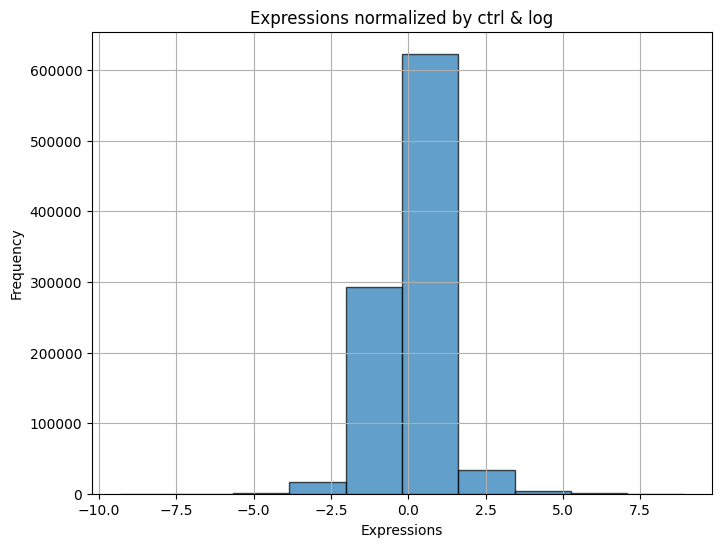

In [75]:
plot_histogram(data_df['stress'], title=f'Expressions normalized by ctrl & log', xlabel='Expressions', bins=10)


# Model Training

In [76]:
config = {
    'lr': 0.0001,
    'batch_size': 1024,
    'epochs': 30,
    'species_id': -1,
    'test_size': 20000,
    'hidden_size': 60,
    'cnn_filters': 100,
    'kernel_size': 8,
    'model_version': 2,
    'stress_condition_size': 11,
}

train_dataset, test_dataset = prepare_datasets(
        species_id=config["species_id"],
        size=config["test_size"],
        data_df=data_df,
    )



In [77]:
net, train_losses, val_losses = train(config, train_dataset)

Started training CNNV3
Training on 20015 samples, testing on 5004 samples
Epoch 0, train loss: 2.579376244544983 validation loss: 0.9312304615974426
Validation loss decreased (inf --> 0.931230).  Saving model ...
Epoch 1, train loss: 2.414193892478943 validation loss: 0.9446466207504273
EarlyStopping counter: 1 out of 10
Epoch 2, train loss: 2.290778696537018 validation loss: 0.9491098523139954
EarlyStopping counter: 2 out of 10
Epoch 3, train loss: 2.1748156547546387 validation loss: 0.9299848437309265
Validation loss decreased (0.931230 --> 0.929985).  Saving model ...
Epoch 4, train loss: 2.102477860450745 validation loss: 0.9116241097450256
Validation loss decreased (0.929985 --> 0.911624).  Saving model ...
Epoch 5, train loss: 1.9988061726093291 validation loss: 0.8923912882804871
Validation loss decreased (0.911624 --> 0.892391).  Saving model ...
Epoch 6, train loss: 1.9998732328414917 validation loss: 0.8787482857704163
Validation loss decreased (0.892391 --> 0.878748).  Savin

# Param tuning

In [78]:
param_dist = {
        'lr': uniform(1e-5, 1e-2),
        'cnn_filters': randint(20, 150),
        'batch_size': randint(512, 2048),
        'hidden_size': randint(10, 150),
        'kernel_size': randint(4, 100),
        'activation': [nn.ReLU(), nn.LeakyReLU(), nn.Tanh()],
    }

best_config, best_net = random_search(train_dataset,  test_size=20000, param_dist=param_dist, n_iter=20)


Started training CNNV3
Training on 20015 samples, testing on 5004 samples
Epoch 0, train loss: 2.068447490533193 validation loss: 0.7965768873691559
Validation loss decreased (inf --> 0.796577).  Saving model ...
Epoch 1, train loss: 1.2873957206805546 validation loss: 0.7842844724655151
Validation loss decreased (0.796577 --> 0.784284).  Saving model ...
Epoch 2, train loss: 1.0193870291113853 validation loss: 0.7802360653877258
Validation loss decreased (0.784284 --> 0.780236).  Saving model ...
Epoch 3, train loss: 0.8962106804052988 validation loss: 0.7787810961405436
Validation loss decreased (0.780236 --> 0.778781).  Saving model ...
Epoch 4, train loss: 0.848269984126091 validation loss: 0.7758171955744425
Validation loss decreased (0.778781 --> 0.775817).  Saving model ...
Epoch 5, train loss: 0.8199115966757139 validation loss: 0.7743560671806335
Validation loss decreased (0.775817 --> 0.774356).  Saving model ...
Epoch 6, train loss: 0.797228549917539 validation loss: 0.77074

/home/igalutz/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 0, train loss: 1.487965420881907 validation loss: 0.7499846667051315
Validation loss decreased (inf --> 0.749985).  Saving model ...
Epoch 1, train loss: 0.8612756609916687 validation loss: 0.7389620691537857
Validation loss decreased (0.749985 --> 0.738962).  Saving model ...
Epoch 2, train loss: 0.7947311242421468 validation loss: 0.7338312417268753
Validation loss decreased (0.738962 --> 0.733831).  Saving model ...
Epoch 3, train loss: 0.7852045694986979 validation loss: 0.7250047624111176
Validation loss decreased (0.733831 --> 0.725005).  Saving model ...
Epoch 4, train loss: 0.7707402427991231 validation loss: 0.7184143513441086
Validation loss decreased (0.725005 --> 0.718414).  Saving model ...
Epoch 5, train loss: 0.7798926711082459 validation loss: 0.7214532941579819
EarlyStopping counter: 1 out of 10
Epoch 6, train loss: 0.7679909865061442 validation loss: 0.7140656262636185
Validation loss decreased (0.718414 --> 0.714066).  Saving model ...
Epoch 7, train loss: 0.76

In [79]:
best_config

{'lr': 0.00984780996653311,
 'cnn_filters': 68,
 'batch_size': 1395,
 'hidden_size': 89,
 'activation': LeakyReLU(negative_slope=0.01),
 'kernel_size': 62,
 'epochs': 50,
 'species_id': -1,
 'test_size': 20000,
 'model_version': 2,
 'stress_condition_size': 11}

# Try best config

In [80]:
config = best_config
#config['activation'] = nn.LeakyReLU()
net, train_losses, val_losses = train(config,train_dataset)



Started training CNNV3
Training on 20015 samples, testing on 5004 samples
Epoch 0, train loss: 1.261582907040914 validation loss: 0.7988487184047699
Validation loss decreased (inf --> 0.798849).  Saving model ...
Epoch 1, train loss: 0.805275805791219 validation loss: 0.7964309900999069
Validation loss decreased (0.798849 --> 0.796431).  Saving model ...
Epoch 2, train loss: 0.7828352610270183 validation loss: 0.790164977312088
Validation loss decreased (0.796431 --> 0.790165).  Saving model ...
Epoch 3, train loss: 0.7766007065773011 validation loss: 0.7933908551931381
EarlyStopping counter: 1 out of 10
Epoch 4, train loss: 0.7606402238210043 validation loss: 0.7890025526285172
Validation loss decreased (0.790165 --> 0.789003).  Saving model ...
Epoch 5, train loss: 0.763454818725586 validation loss: 0.7740096151828766
Validation loss decreased (0.789003 --> 0.774010).  Saving model ...
Epoch 6, train loss: 0.7559687058130901 validation loss: 0.7999329268932343
EarlyStopping counter: 

# Test

In [83]:
# Test configuration
config = {
    'batch_size': 1024,
}

# Run predictions
predictions, labels, species_ids, all_stress_ids = predict(config, net, test_dataset)

# Evaluate regression metrics
mse, mae, r2 = evaluate(predictions, labels)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.742274820804596
Mean Absolute Error: 0.5690624713897705
R-squared: 0.10608738660812378


In [84]:
predictions, labels

(array([ 0.06508338,  0.12222677, -0.0186478 , ...,  0.02011523,
         0.05182052, -0.25749144], dtype=float32),
 array([ 0.12861522, -0.09618368,  0.02513948, ...,  0.4834227 ,
        -0.23629634,  0.85701317], dtype=float32))

In [85]:
predictions_inv, labels_inv = inverse_normalize(predictions), inverse_normalize(labels)
predictions_inv, labels_inv

(array([ 0.06724811,  0.13001037, -0.018475  , ...,  0.02031887,
         0.05318666, -0.2270118 ], dtype=float32),
 array([ 0.13725245, -0.09170282,  0.02545822, ...,  0.6216152 ,
        -0.21045333,  1.356113  ], dtype=float32))

# Plots

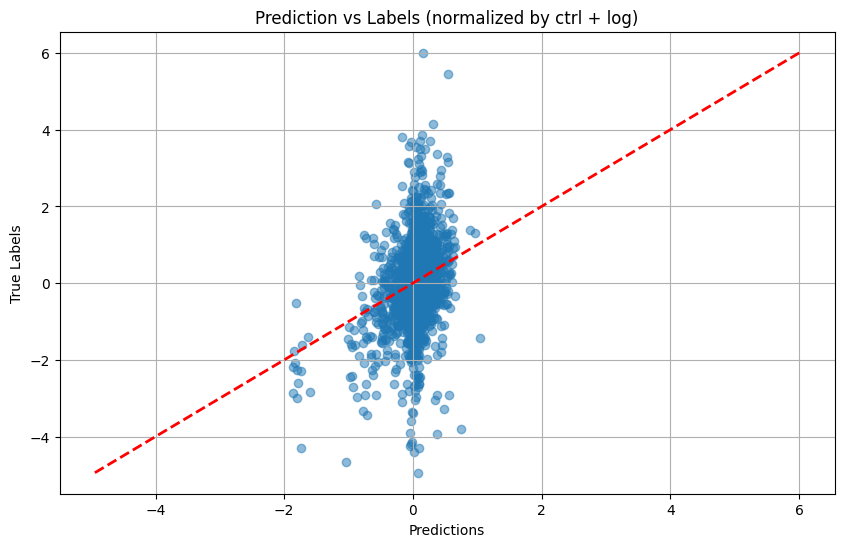

In [86]:
plot_predictions_vs_labels(predictions, labels, title='Prediction vs Labels (normalized by ctrl + log)')


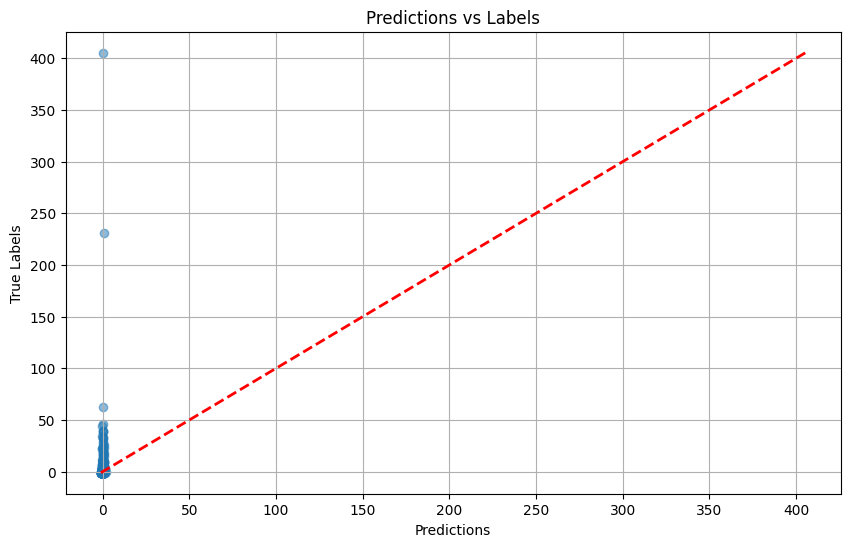

In [87]:
plot_predictions_vs_labels(predictions_inv, labels_inv)


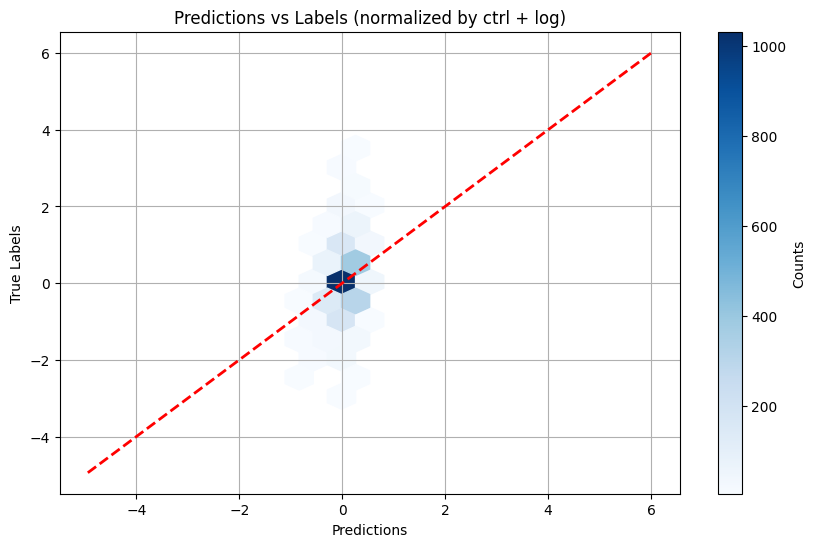

In [88]:
plot_hexbin_predictions_vs_labels(predictions, labels, title="Predictions vs Labels (normalized by ctrl + log)", gridsize=20, mincnt=5)

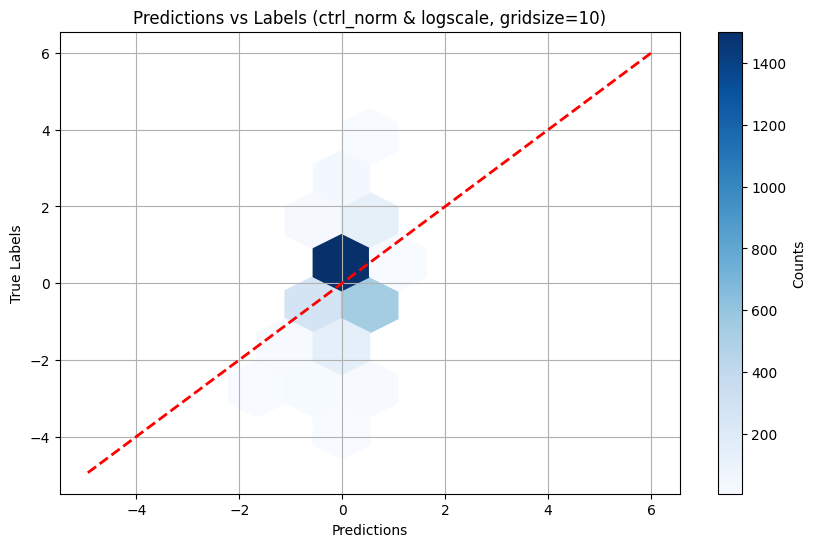

In [89]:
plot_hexbin_predictions_vs_labels(predictions, labels, title="Predictions vs Labels (ctrl_norm & logscale, gridsize=10)", gridsize=10, mincnt=5)

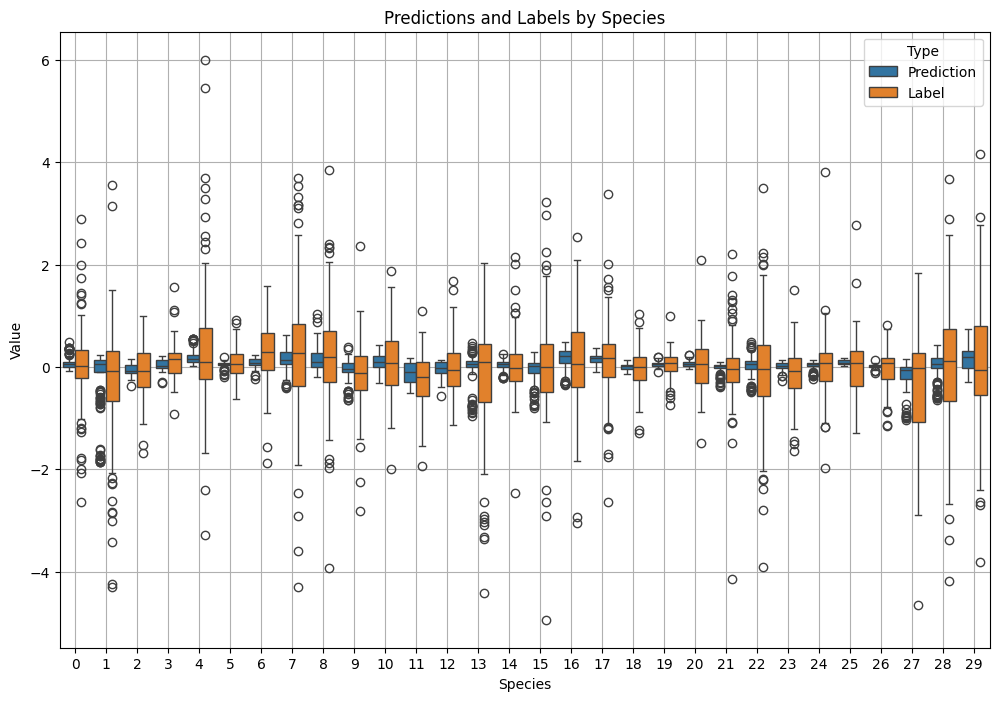

In [90]:
plot_boxplot_predictions_vs_labels(predictions, labels, species_ids, by_label='Species')

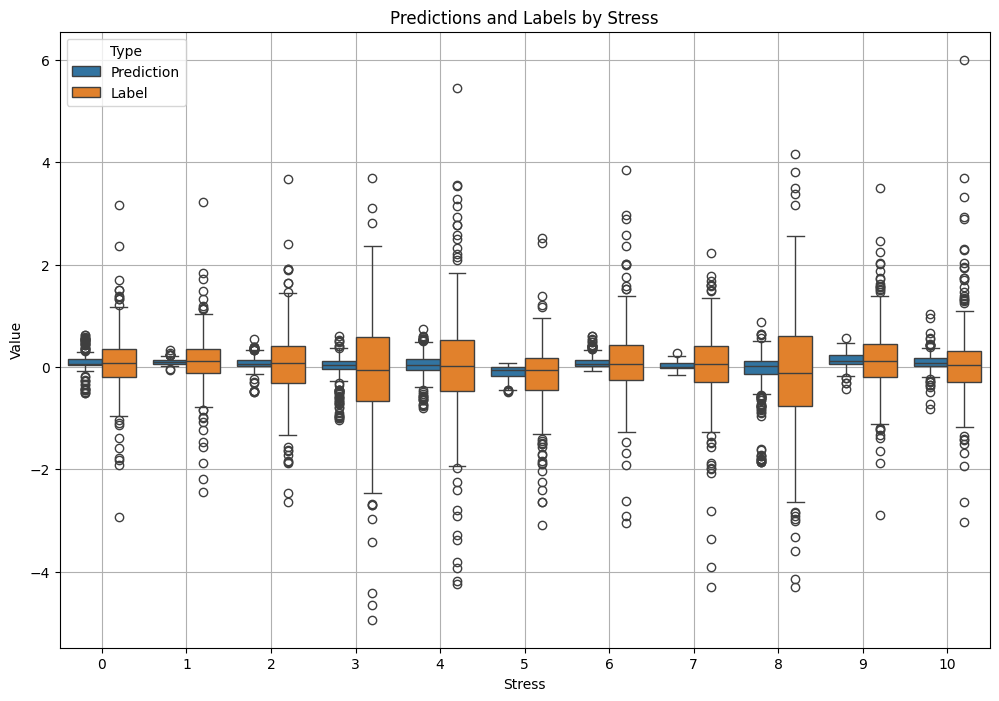

In [91]:
# Plot the boxplot
plot_boxplot_predictions_vs_labels(predictions, labels, all_stress_ids, by_label='Stress')

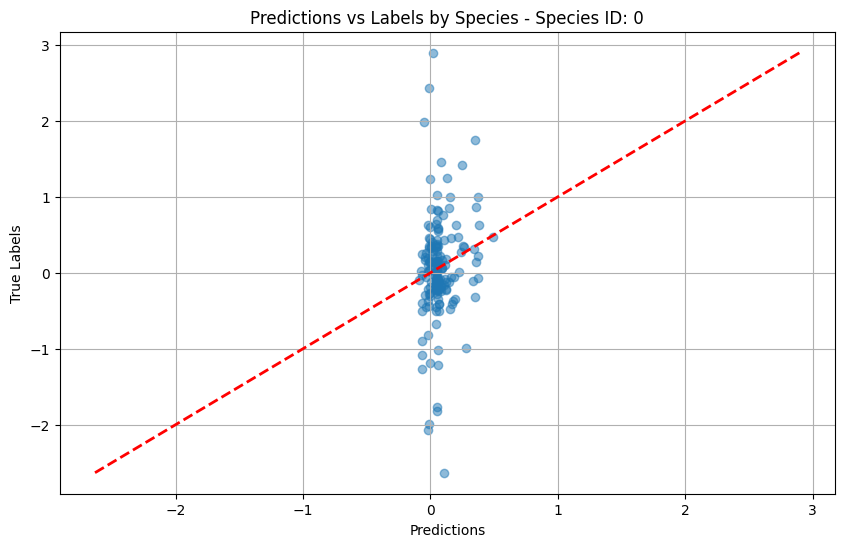

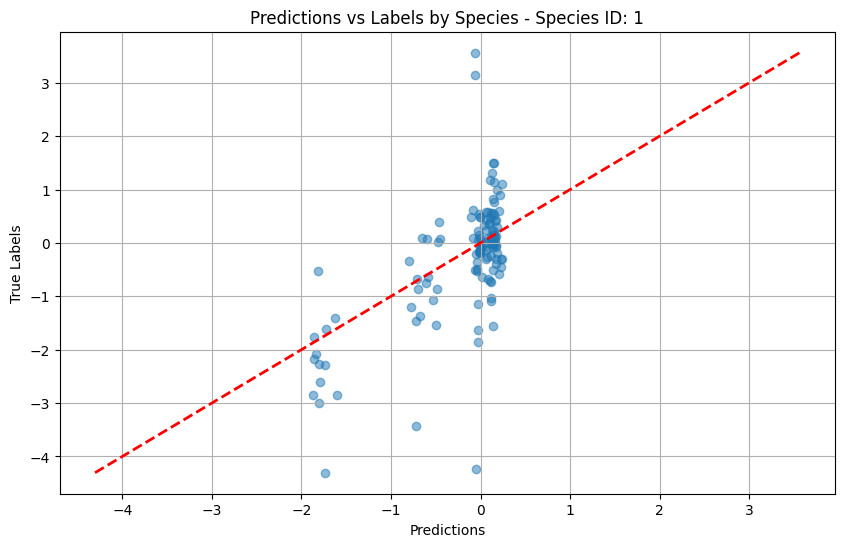

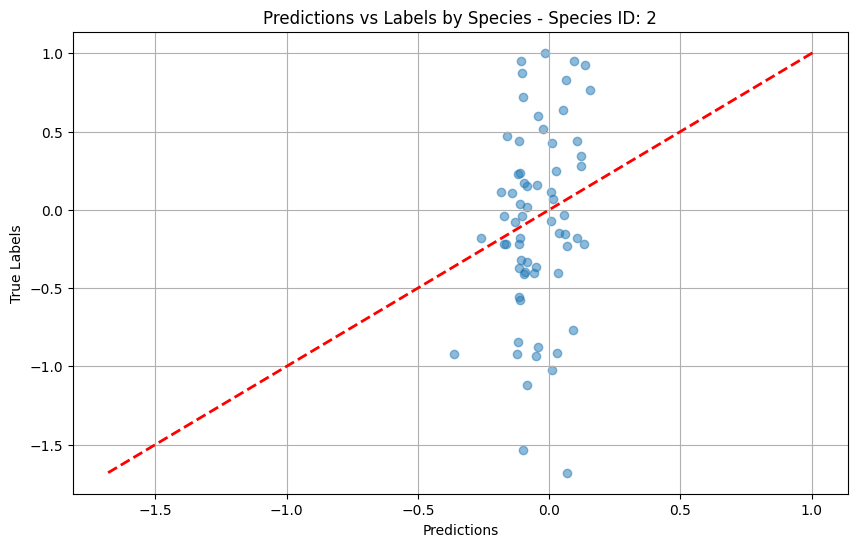

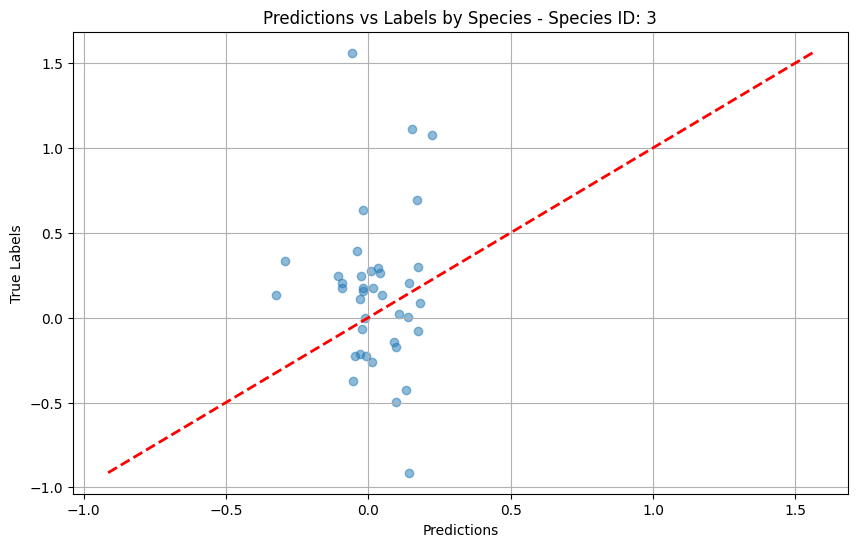

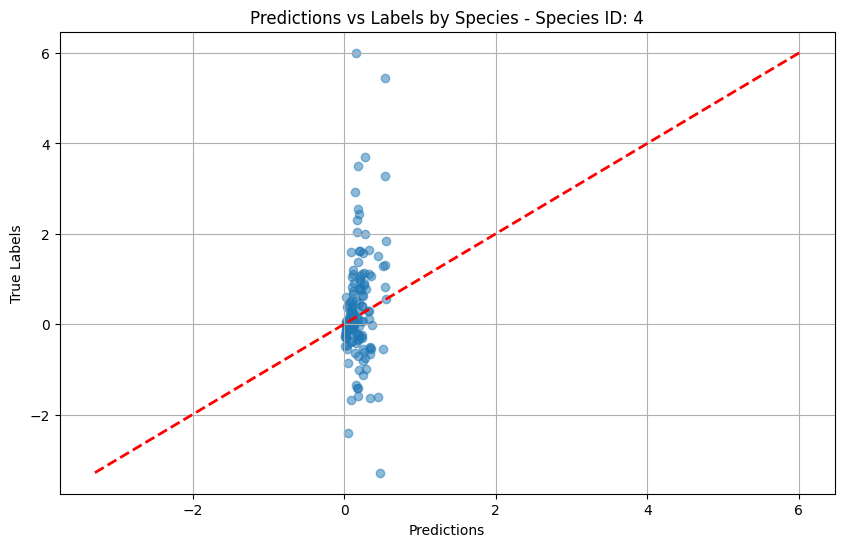

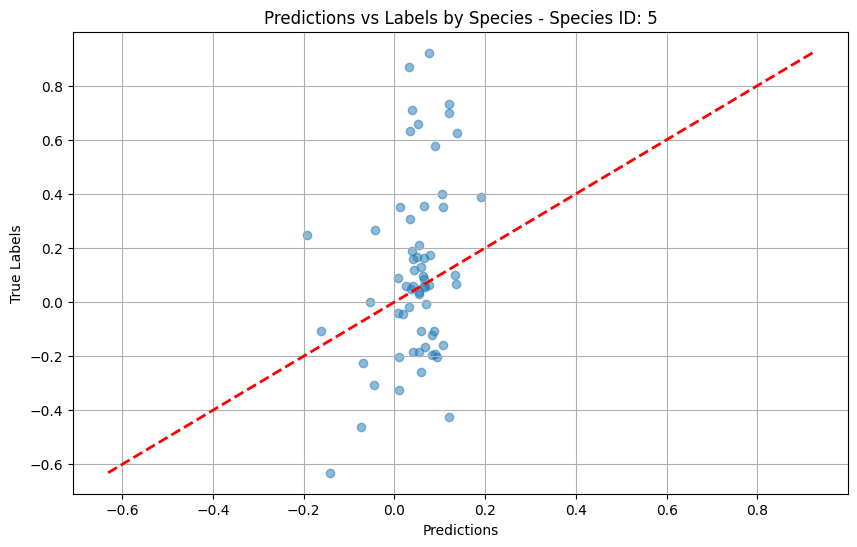

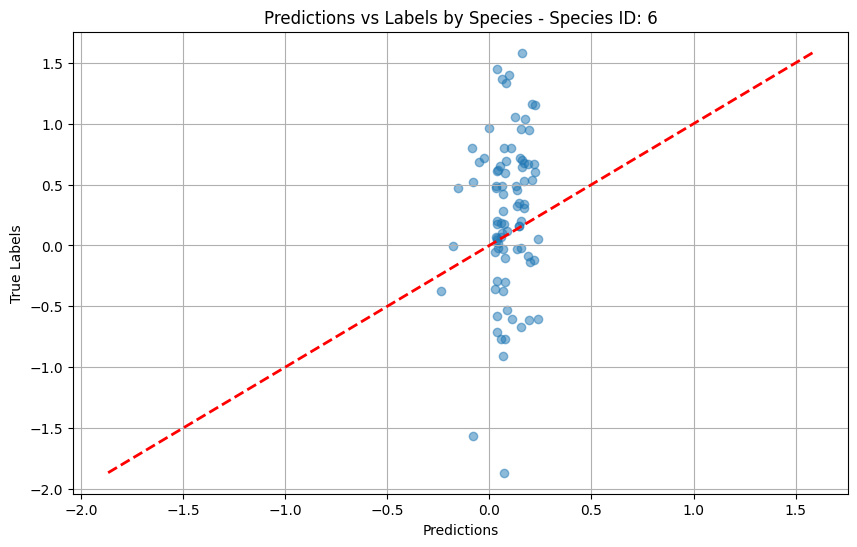

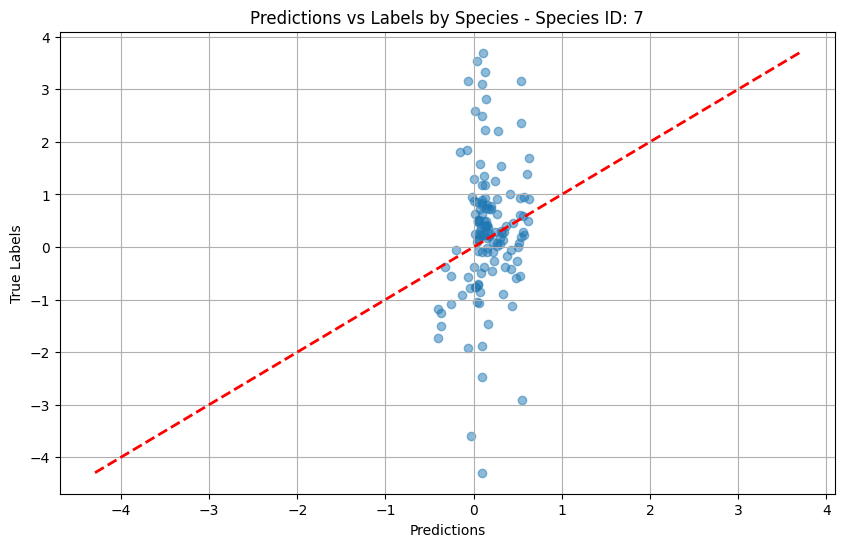

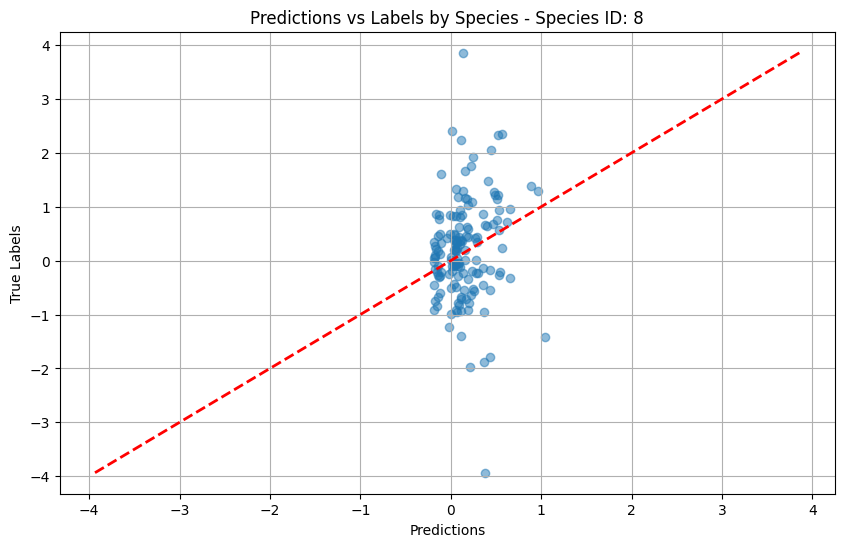

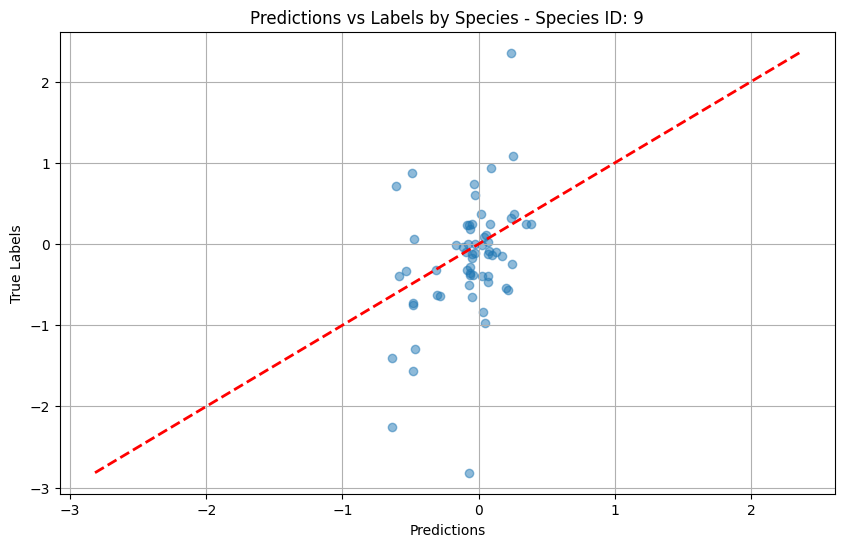

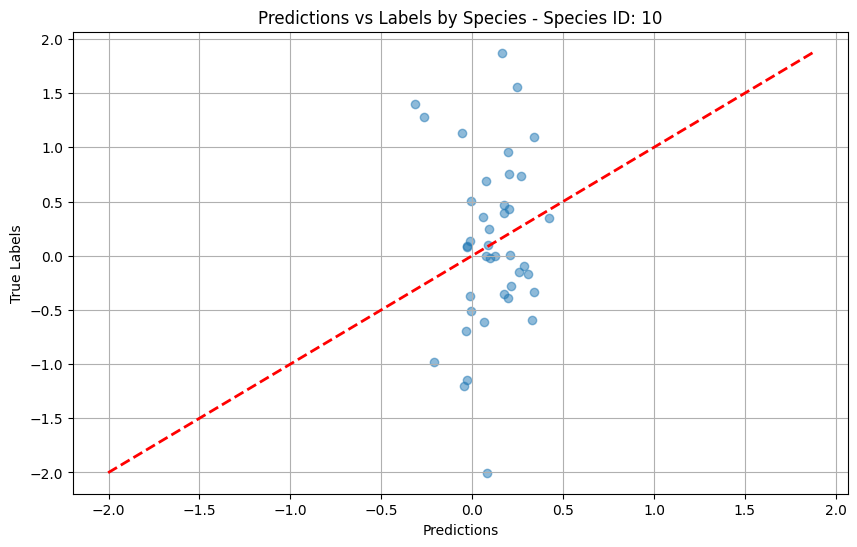

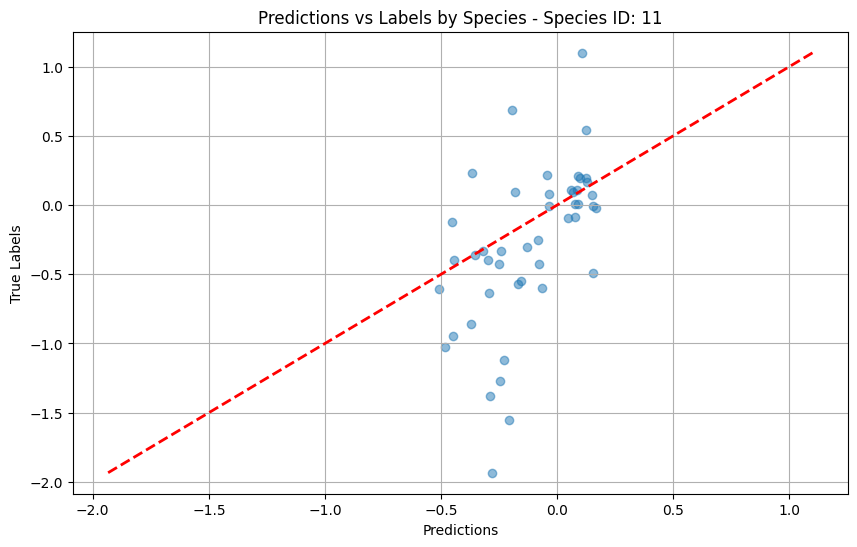

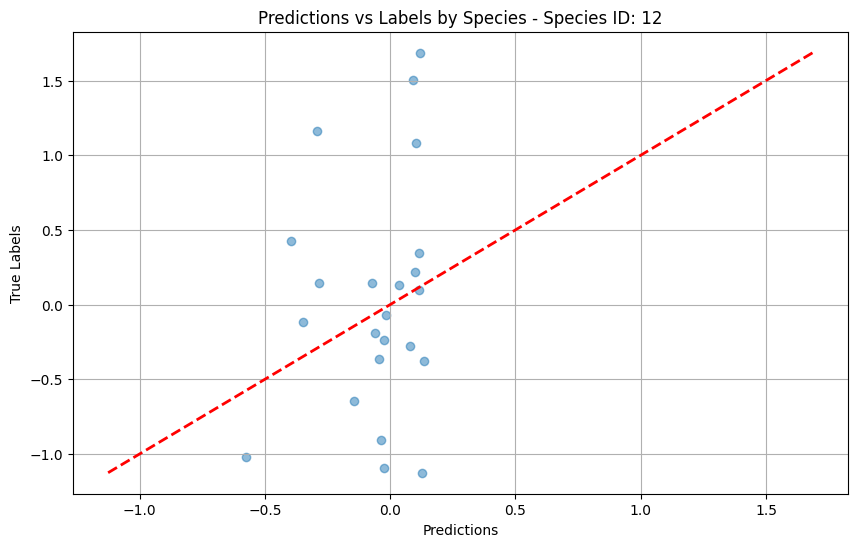

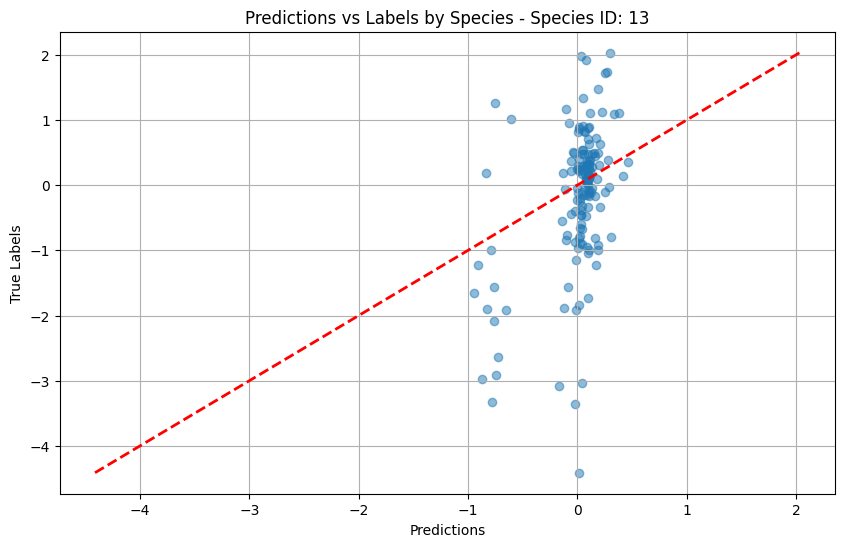

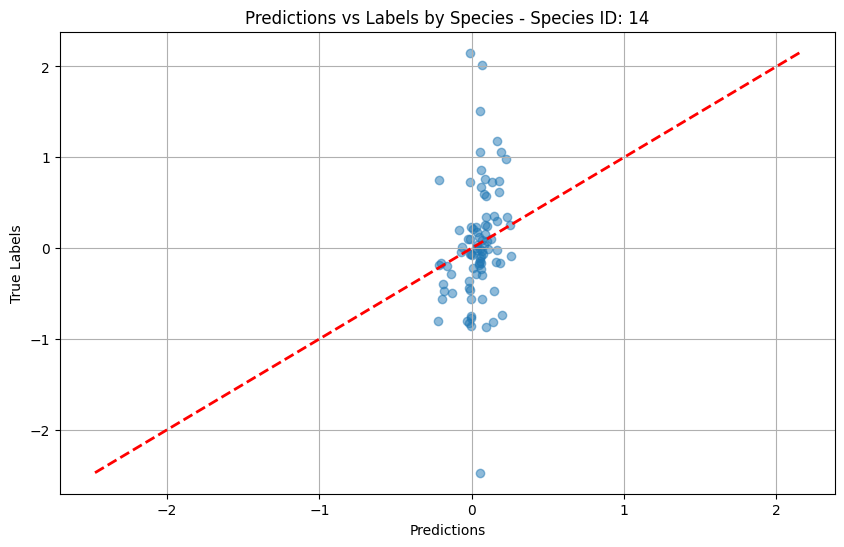

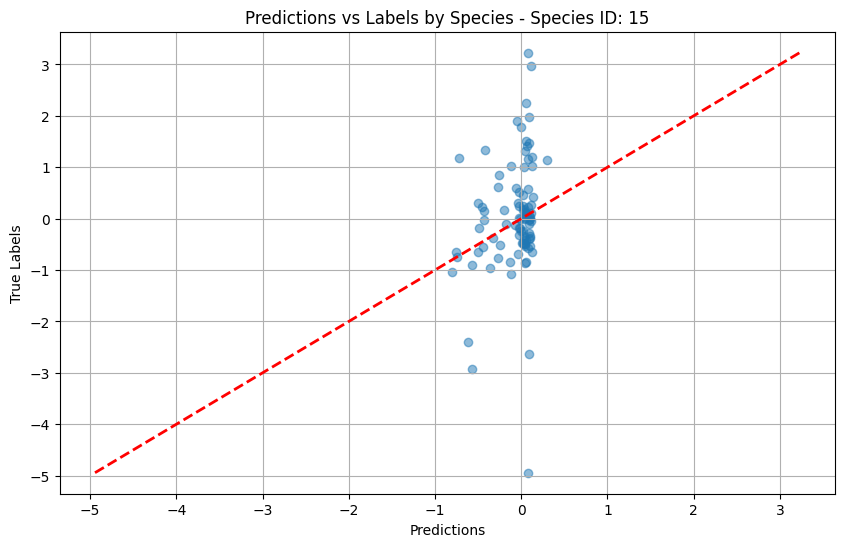

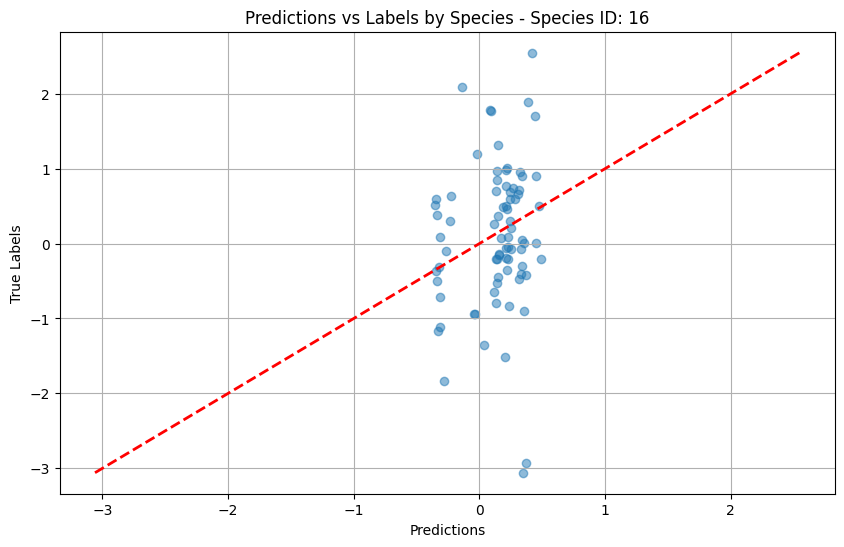

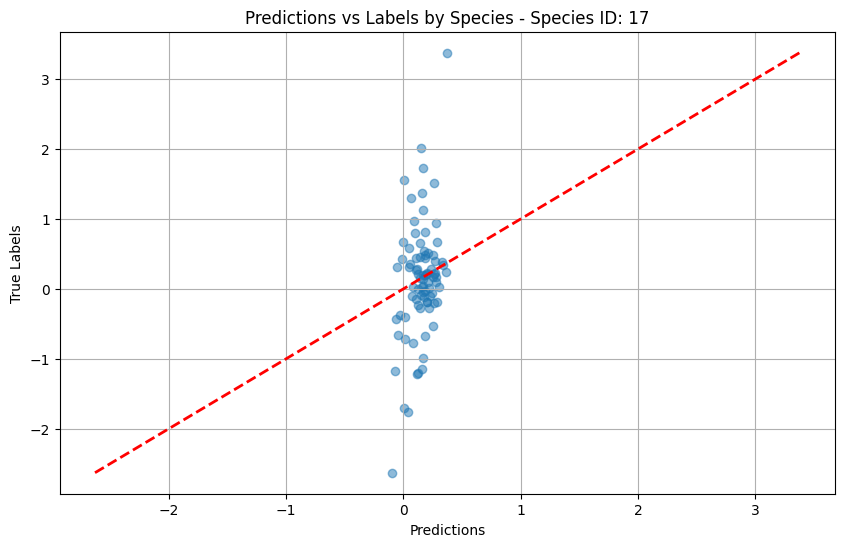

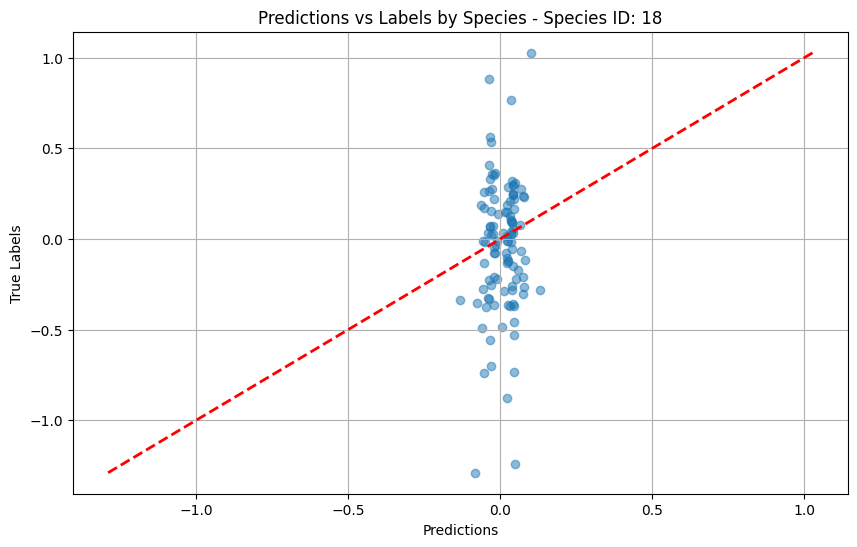

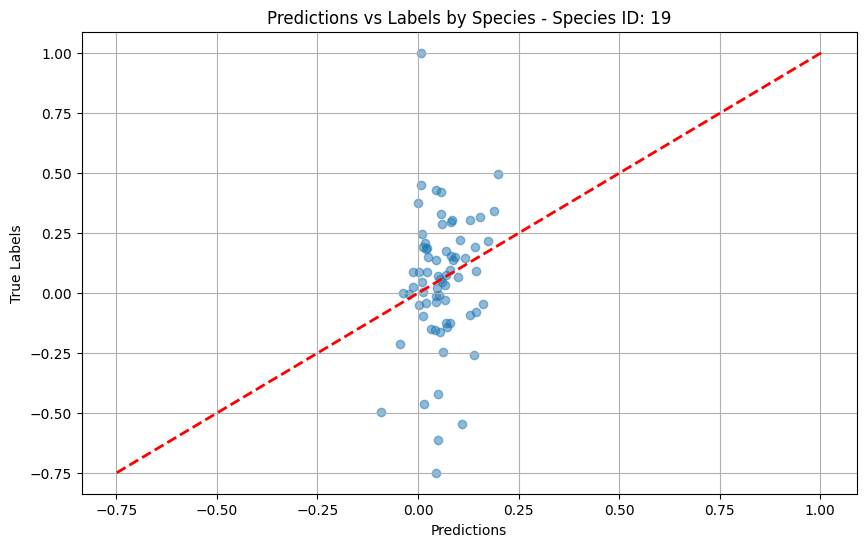

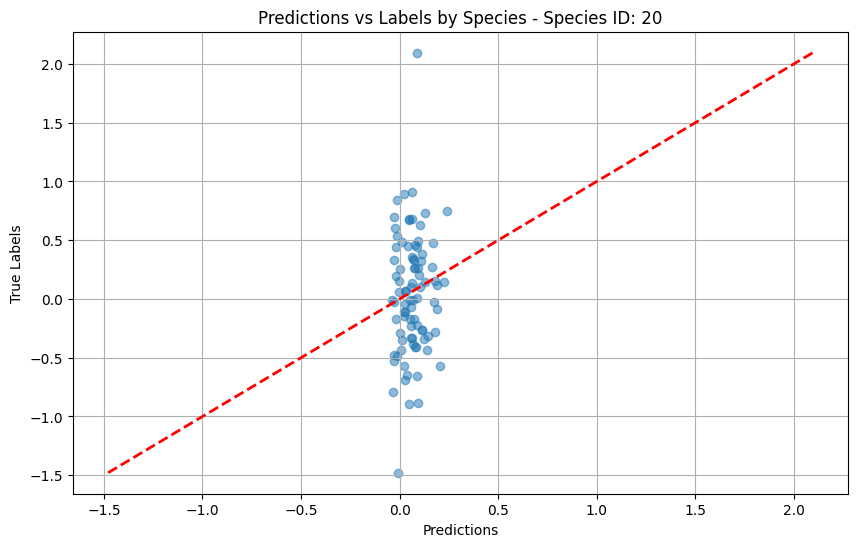

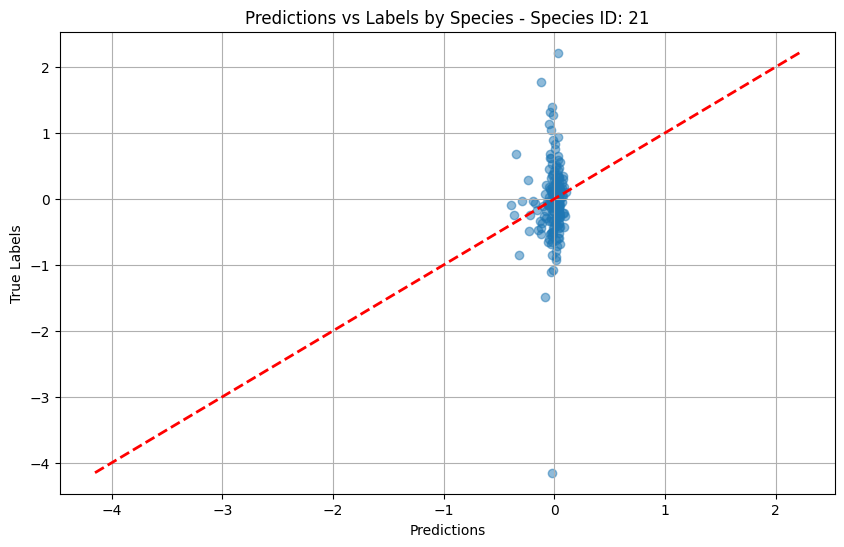

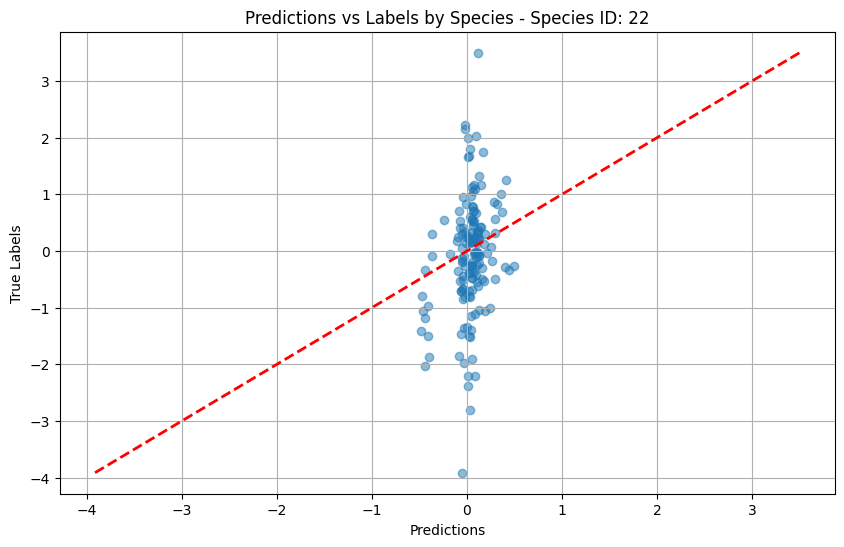

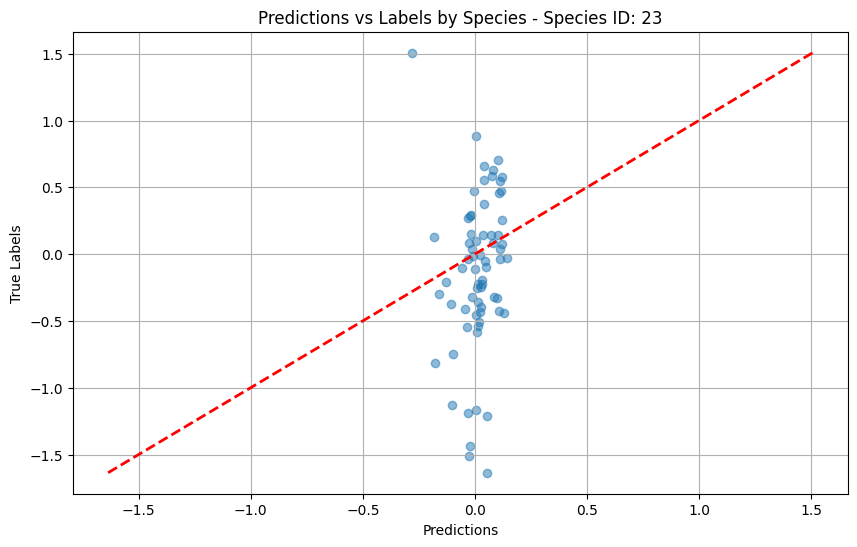

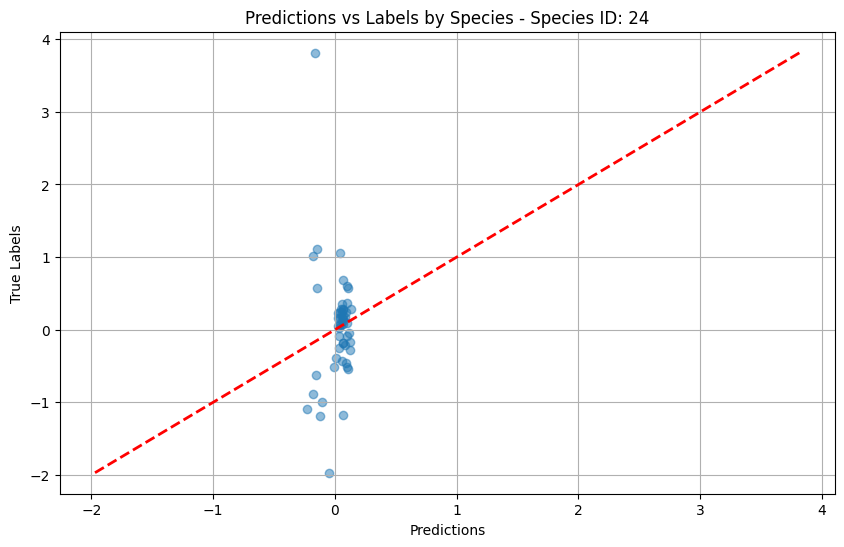

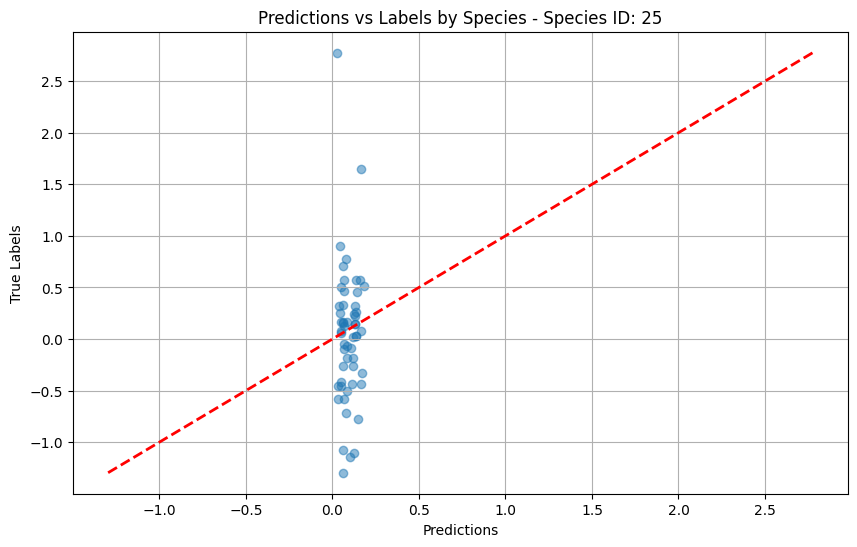

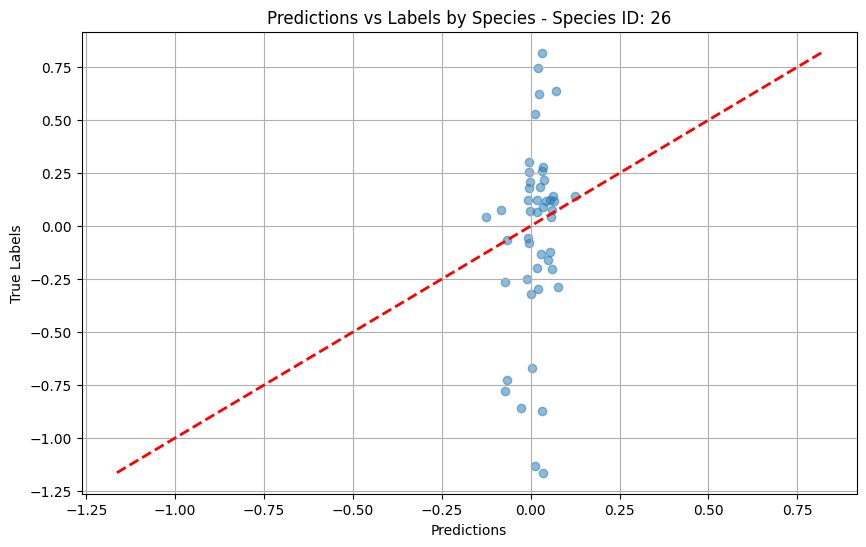

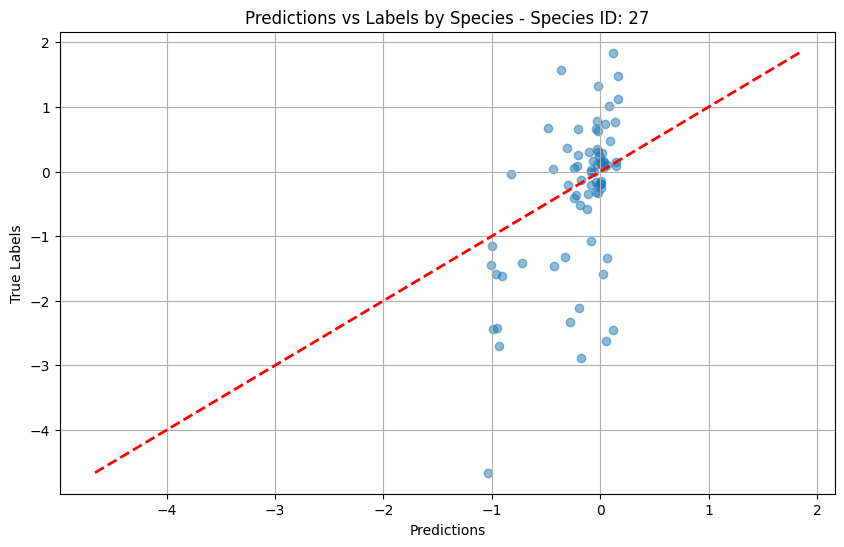

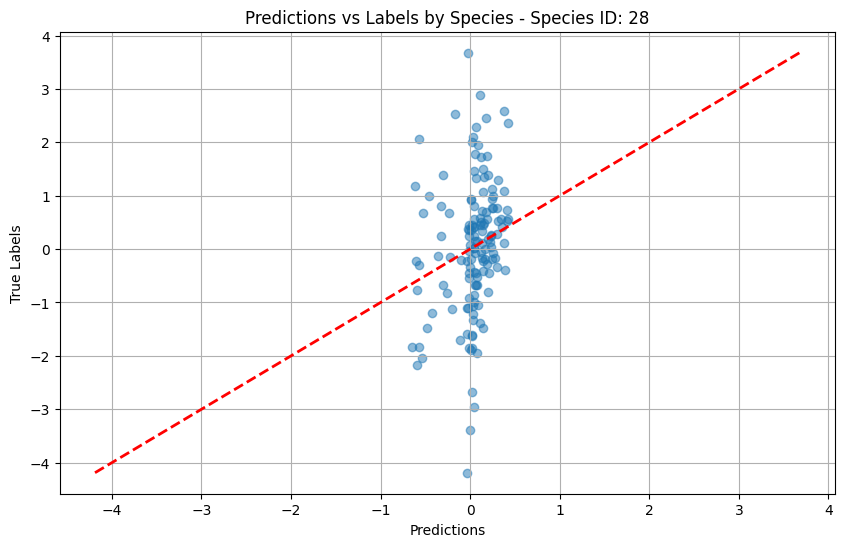

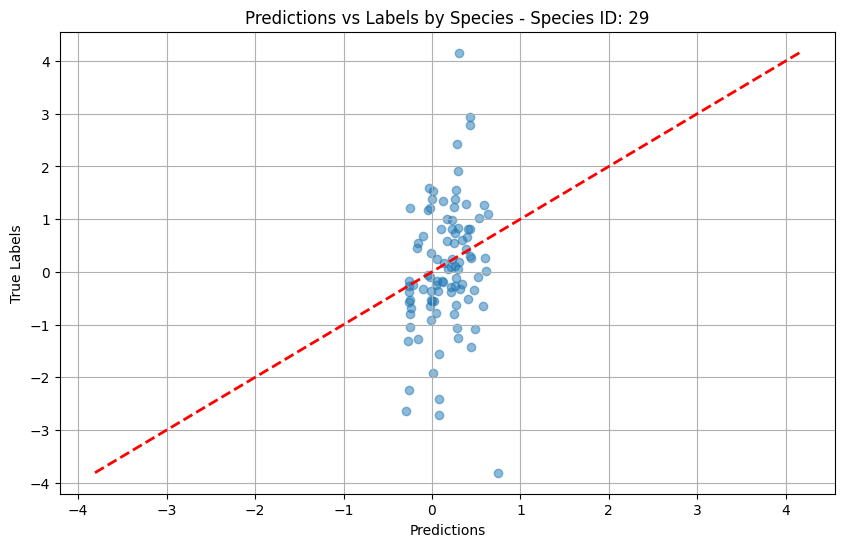

In [92]:
plot_predictions_vs_labels_by_species(predictions, labels, species_ids)


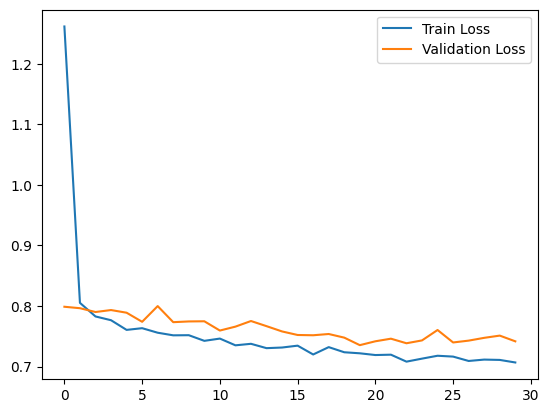

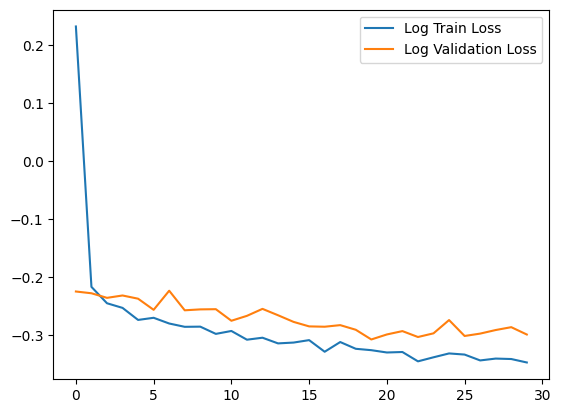

In [93]:
plot_losses(train_losses, val_losses)

30

In [118]:

metrics = pd.DataFrame(columns=['species', 'mse', 'mae', 'r2', 'mse_test', 'mae_test', 'r2_test'])

for spec_id in tqdm(range(30)):

    spec_train_dataset, spec_test_dataset = prepare_datasets(
            species_id=spec_id,
            size=-1,
            data_df=data_df,
        )


    predictions, labels, species_ids, all_stress_ids = predict(config, net, spec_train_dataset)
    predictions_test, labels_test, species_ids_test, all_stress_ids_test = predict(config, net, spec_test_dataset)

    # Evaluate regression metrics

    mse, mae, r2 = evaluate(predictions, labels)
    mse_test, mae_test, r2_test = evaluate(predictions_test, labels_test)
    metrics.loc[spec_id] = [spec_id, mse, mae, r2, mse_test, mae_test, r2_test]




  0%|          | 0/30 [00:00<?, ?it/s]/home/igalutz/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
  3%|▎         | 1/30 [00:12<05:57, 12.33s/it]/home/igalutz/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
  7%|▋         | 2/30 [00:20<04:43, 10.12s/it]/home/igalutz/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BA

In [120]:
# r2 for spec 1 
metrics[metrics['species'] == 1]

,species,mse,mae,r2,mse_test,mae_test,r2_test
1,1.0,0.62744,0.551285,0.409338,0.669839,0.56354,0.380457


<Axes: title={'center': 'MAE_test by species'}, xlabel='species'>

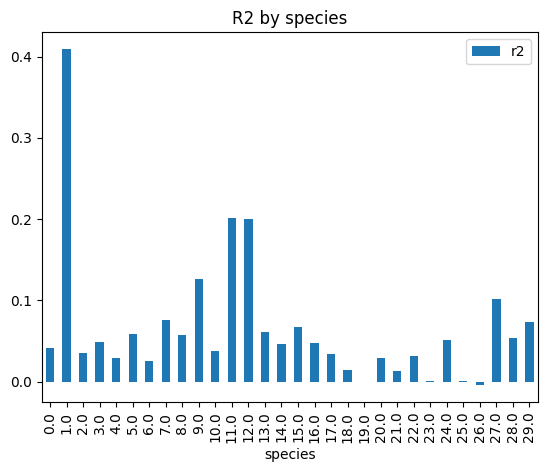

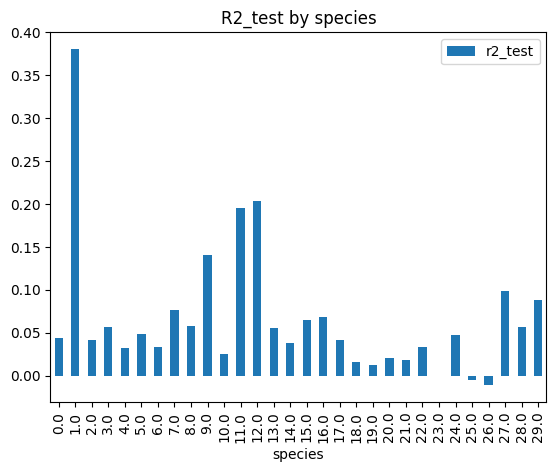

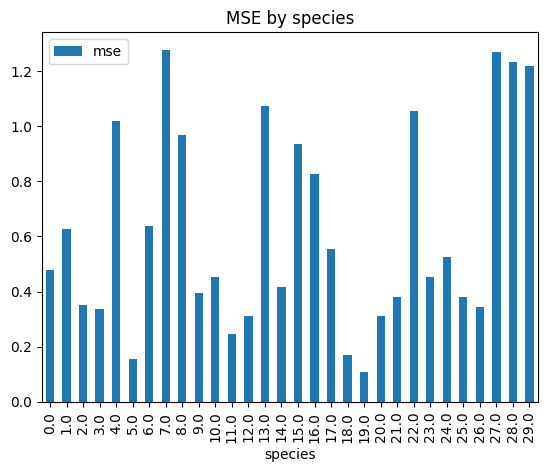

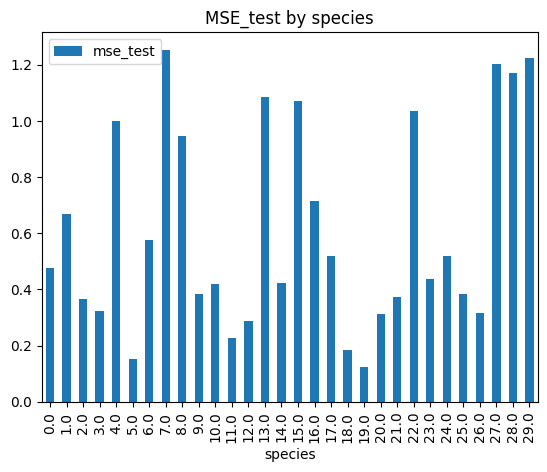

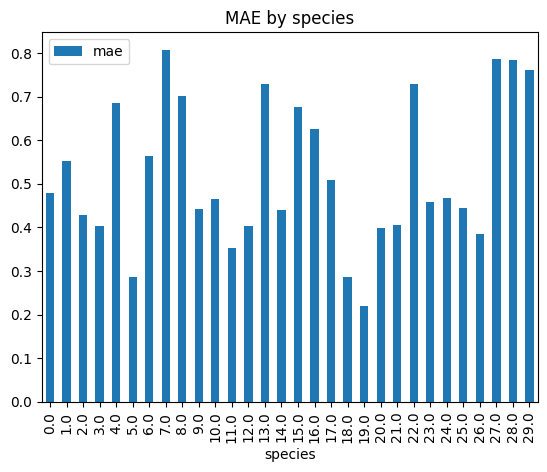

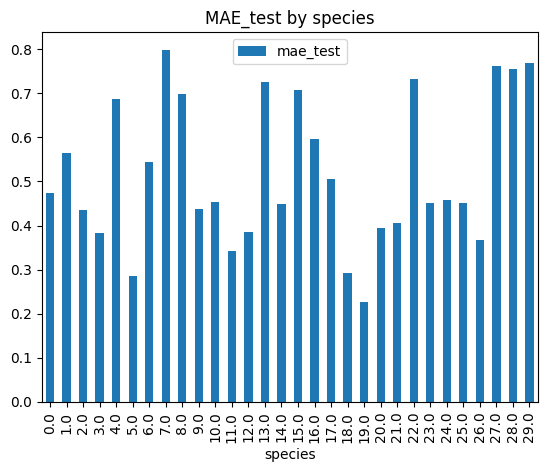

In [119]:
# plot r2 metrics in bar chart
metrics.plot(kind='bar', x='species', y='r2', title='R2 by species')
metrics.plot(kind='bar', x='species', y='r2_test', title='R2_test by species')
metrics.plot(kind='bar', x='species', y='mse', title='MSE by species')
metrics.plot(kind='bar', x='species', y='mse_test', title='MSE_test by species')
metrics.plot(kind='bar', x='species', y='mae', title='MAE by species')
metrics.plot(kind='bar', x='species', y='mae_test', title='MAE_test by species')
